In [1]:
# Cell 1: Imports
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [2]:
# Cell 2: Load and Preprocess Data
import os
def load_data(path, label):
    reviews = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as f:
            reviews.append(f.read())
    return pd.DataFrame({'review': reviews, 'label': label})

train_pos_path = '../data/raw/aclImdb/train/pos'
train_neg_path = '../data/raw/aclImdb/train/neg'
train_pos = load_data(train_pos_path, 'positive')
train_neg = load_data(train_neg_path, 'negative')
train_data = pd.concat([train_pos, train_neg], ignore_index=True)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab', download_dir='~/nltk_data')
nltk.data.path.append('~/nltk_data')

stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    if not isinstance(text, str):
        return ""
    try:
        text = re.sub(r'<[^>]+>', '', text)
        text = re.sub(r'[^\w\s]', '', text)
        tokens = word_tokenize(text.lower())
        tokens = [word for word in tokens if word not in stop_words and word]
        return ' '.join(tokens)
    except Exception as e:
        print(f"Error preprocessing text: {e}")
        return ""

train_data['clean_review'] = train_data['review'].apply(preprocess_text)
y = train_data['label'].map({'positive': 1, 'negative': 0})

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rashidkarimov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to ~/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [3]:
# Cell 3: Advanced Feature Engineering
max_words = 10000  # Max number of words to keep
max_len = 200      # Max length of each review (in words)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data['clean_review'])
sequences = tokenizer.texts_to_sequences(train_data['clean_review'])
X = pad_sequences(sequences, maxlen=max_len)

embedding_dim = 100  # Dimension of embedding (adjust based on GloVe if used)

word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

In [4]:
# Cell 4: Build and Train LSTM Model
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)

model = Sequential([
    Embedding(num_words, embedding_dim, input_length=max_len),
    LSTM(128, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')  # 2 classes: positive/negative
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, validation_data=(X_val, y_val_cat), 
                   epochs=5, batch_size=64, verbose=1)

/Users/rashidkarimov/Desktop/sentiment_analysis_project/tf_env/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 83s 259ms/step - accuracy: 0.7341 - loss: 0.5041 - val_accuracy: 0.8736 - val_loss: 0.3046
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 291ms/step - accuracy: 0.9225 - loss: 0.2093 - val_accuracy: 0.8786 - val_loss: 0.2950
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 91s 290ms/step - accuracy: 0.9591 - loss: 0.1209 - val_accuracy: 0.8720 - val_loss: 0.3298
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 273ms/step - accuracy: 0.9744 - loss: 0.0779 - val_accuracy: 0.8600 - val_loss: 0.4936
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 85s 271ms/step - accuracy: 0.9821 - loss: 0.0540 - val_accuracy: 0.8620 - val_loss: 0.4765


157/157 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step
LSTM Validation Accuracy: 0.862

LSTM Classification Report:
              precision    recall  f1-score   support

    negative       0.87      0.85      0.86      2485
    positive       0.85      0.88      0.86      2515

    accuracy                           0.86      5000
   macro avg       0.86      0.86      0.86      5000
weighted avg       0.86      0.86      0.86      5000



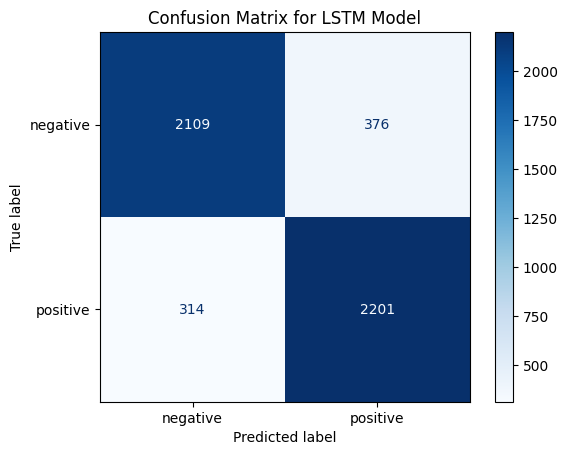

In [5]:
# Cell 5: Evaluate and Analyze LSTM Performance
y_pred_lstm = model.predict(X_val)
y_pred_classes = np.argmax(y_pred_lstm, axis=1)

lstm_accuracy = accuracy_score(y_val, y_pred_classes)
print("LSTM Validation Accuracy:", lstm_accuracy)
print("\nLSTM Classification Report:")
print(classification_report(y_val, y_pred_classes, target_names=['negative', 'positive']))

cm_lstm = confusion_matrix(y_val, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_lstm, display_labels=['negative', 'positive'])
disp.plot(cmap='Blues')
plt.title('Confusion Matrix for LSTM Model')
plt.savefig('../output/figures/confusion_matrix_lstm.png')
plt.show()

In [6]:
# Cell 6: Explore Error Patterns
val_data = train_data.iloc[y_val.index].copy()
val_data['predicted_lstm'] = y_pred_classes

misclassified_lstm = val_data[val_data['label'].map({'positive': 1, 'negative': 0}) != y_pred_classes]

print("\nSample Misclassified Reviews (LSTM):")
for _, row in misclassified_lstm.head(5).iterrows():
    print(f"\nReview: {row['clean_review'][:200]}...")
    print(f"True Label: {row['label']}")
    print(f"Predicted Label: {'positive' if row['predicted_lstm'] == 1 else 'negative'}")


Sample Misclassified Reviews (LSTM):

Review: saw film belgrade film festival last week im still working trauma essentially view seems match number others first half hour fresh sharp deep entertaining promising well acted natural problem however ...
True Label: negative
Predicted Label: positive

Review: modern viewers know little film primarily model remake money pit older viewers today watch wisps nostalgia cary grant myrna loy melvyn douglas superstars easier less complicated era time course way mo...
True Label: positive
Predicted Label: negative

Review: first anyone thinks sequel william friedkins french connection superior definitely completely insane moronic problem reviewing film sequel brilliant movie always makes watching objectively difficult b...
True Label: negative
Predicted Label: positive

Review: like many horror fans force fed banal big budget hollywood remakes mtv high school slasher tripe last 20 years last original horror genre movie ticks right boxesyou want hot